In [1]:
# -*- coding: utf-8 -*-
import sys
sys.path.append('/Users/jun/PersonReID_Research/HRNetReID')
import torch
from torch import nn, optim
from torch.nn import init
from torchvision import datasets, transforms 
from torchinfo import summary
from torch.nn import functional as F
import matplotlib.pyplot as plt
import matplotlib
import time 
import os
import random
import tqdm.auto as tqdm

from model import * 
from utils.random_erasing import RandomErasing
from utils.dgfolder import DGFolder
import yaml
from shutil import copyfile
from utils.circle_loss import CircleLoss, convert_label_to_similarity
from utils.instance_loss import InstanceLoss
from net.pspnet import PSPNet
from hrnet.seg_hrnet import HighResolutionNet, HRNet_2Head
from online_triplet_loss.losses import *
import timm
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
from config.default import _C as config
config.defrost()
config.merge_from_file('/Users/jun/PersonReID_Research/HRNetReID/config_yml/seg_hrnet_w48.yaml')
config.freeze()
proxy = 'http://10.0.0.107:3128'
os.environ['http_proxy'] = proxy 
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

/Users/jun/miniforge3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
#device = 'cpu'

In [4]:
parsing_model = SegmentationHRNet(config) # segmentation model
parsing_model.load_state_dict(torch.load('/Users/jun/PersonReID_Research/pretrained_models/hrnetv2_224_lip_six.pth', map_location=torch.device(device)))

=> init weights from normal distribution
=> loading pretrained model /Users/jun/PersonReID_Research/pretrained_models/hrnetv2_w48_imagenet_pretrained_2.pth


<All keys matched successfully>

In [5]:
model = PSPNet(sizes=(1, 2, 3, 6), psp_size=1024, n_classes = 2, deep_features_size=512)
model.load_state_dict(torch.load('/home/jun/pretrained_models/binary_parsing.pth'))
model = model.to(device)

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Import library
from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/Users/jun/PersonReID_Research/dataset/original/duke')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
test_list = sorted(list(raw_data_dir.glob('gallery/*.jpg')))

In [22]:
def ground_erasing(img_path, model):
    transform = transforms.Compose([
            transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    output = {}
    original = Image.open(img_path)
    w = original.size[0] 
    h = original.size[1]
    resize = transforms.Resize((h, w), interpolation=3)
    original_name = img_path.name
        
    # Transform image for model input
    img = transform(original).unsqueeze(0)
    img = img.to(next(model.parameters()).device)
    with torch.inference_mode():
        pred,_ = model(img)
        

    #output[original_name] = Image.fromarray(img.astype(np.uint8))
    pred = resize(pred) 
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
    new_img = np.array(original).copy()
    new_img[pred == 0] = [0]
    
    segmentation_map = Image.fromarray((pred * 255).astype(np.uint8), mode='L')
    
    new_img = Image.fromarray(new_img.astype(np.uint8)) 
    return original, segmentation_map, new_img

def ground_erasing_hr(img_path, model):
    transform = transforms.Compose([
            transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    output = {}
    original = Image.open(img_path)
    w = original.size[0] 
    h = original.size[1]
    resize = transforms.Resize((h, w), interpolation=3)
    original_name = img_path.name
        
    # Transform image for model input
    img = transform(original).unsqueeze(0)
    img = img.to(next(model.parameters()).device)
    with torch.inference_mode():
        pred = model(img)
    
    pred = F.softmax(pred, dim=1)
    background = pred[:,0:1,:,:]
    pred = torch.cat((background, 1-background),dim = 1)

    #output[original_name] = Image.fromarray(img.astype(np.uint8))
    pred = resize(pred) 
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
    new_img = np.array(original).copy()
    new_img[pred == 0] = [0]
    
    segmentation_map = Image.fromarray((pred * 255).astype(np.uint8), mode='L')
    
    new_img = Image.fromarray(new_img.astype(np.uint8)) 
    return original, segmentation_map, new_img

def twin_ground_erasing_hr(img_path, model):
    transform = transforms.Compose([
            transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    output = {}
    original = Image.open(img_path)
    w = original.size[0] 
    h = original.size[1]
    resize = transforms.Resize((h, w), interpolation=3)
    original_name = img_path.name
        
    # Transform image for model input
    img = transform(original).unsqueeze(0)
    img = img.to(next(model.parameters()).device)
    with torch.inference_mode():
        pred = model(img)
    
    pred = F.softmax(pred, dim=1)
    background = pred[:,0:1,:,:]
    pred = torch.cat((background, 1-background),dim = 1)
        
    #output[original_name] = Image.fromarray(img.astype(np.uint8))
    pred = resize(pred) 
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
        
    replace_dict = {0:'foreground', 1:'nohead', 2:'nobody', 3:'noarms', 4:'nolegs', 5:'nofeets'}
    new_img = np.array(original).copy()
    new_img[pred == 0] = [0,0,0]
    output = np.hstack((original, new_img)) 
    segmentation_map = Image.fromarray((pred * 255).astype(np.uint8), mode='L')
    output = Image.fromarray(output.astype(np.uint8)) 
    foreground_img = Image.fromarray(new_img.astype(np.uint8))  
    return original, segmentation_map, foreground_img, output
    output.save(img_path)

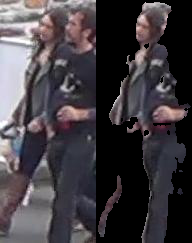

In [101]:
visualize = list(twin_ground_erasing_hr(train_list[510],parsing_model))
visualize[3]

In [102]:
visualize[2].save('/Users/jun/Desktop/ErrorParsing/4_1.png')

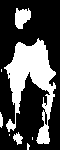

In [53]:
visualize[1]

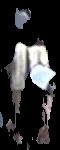

In [52]:
visualize[2]

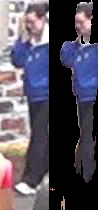

In [70]:
visualize[3]

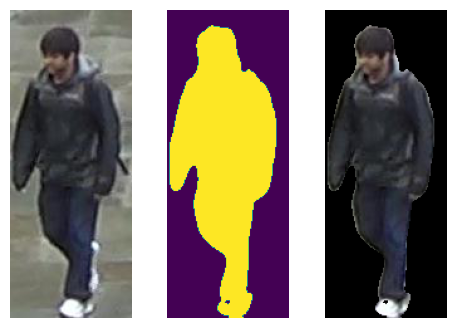

In [37]:
visualize = list(ground_erasing(train_list[5],model))
nrows = 1
ncols = len(visualize)
fig = plt.figure(figsize=(2*ncols, 4*nrows))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for row in range(nrows):
    for col in range(ncols):
        position = row * ncols + col + 1
        ax = plt.subplot(nrows, ncols, position)
        ax.imshow(visualize[col])
        ax.axis(False)

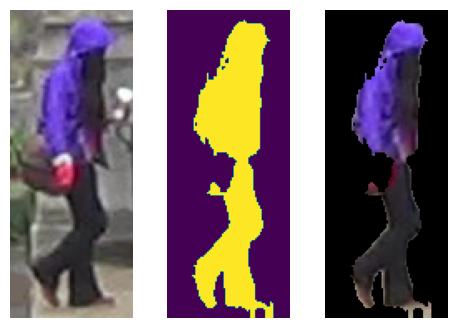

In [36]:
visualize = list(ground_erasing_hr(train_list[751],parsing_model))
nrows = 1
ncols = len(visualize)
fig = plt.figure(figsize=(2*ncols, 4*nrows))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for row in range(nrows):
    for col in range(ncols):
        position = row * ncols + col + 1
        ax = plt.subplot(nrows, ncols, position)
        ax.imshow(visualize[col])
        ax.axis(False)

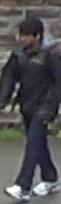

In [11]:
img

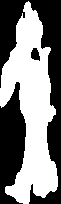

In [13]:
seg_map

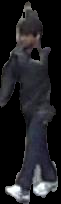

In [14]:
seg_img

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


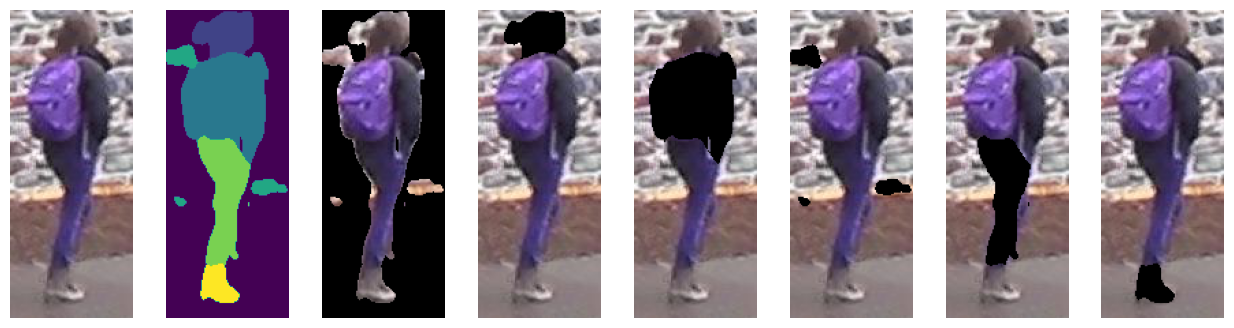

In [10]:
output = segmentation_augmentation(train_list[300], model)
visualize = []
for value in output.values():
    visualize.append(value)
nrows = 1
ncols = len(visualize)
fig = plt.figure(figsize=(2*ncols, 4*nrows))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for row in range(nrows):
    for col in range(ncols):
        position = row * ncols + col + 1
        ax = plt.subplot(nrows, ncols, position)
        ax.imshow(visualize[col])
        ax.axis(False)